In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Layer
import tensorflow as tf

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make the directories
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

In [6]:
# http://vis-www.cs.umass.edu/lfw/

In [7]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

tar: Error opening archive: Failed to open 'lfw.tgz'


In [8]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [9]:
# Import uuid library to generate unique image names
import uuid

In [10]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\ba36821b-c2c6-11ef-85b9-3003c80f03d8.jpg'

In [11]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250, 200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0xFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor imageq
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefullyq
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

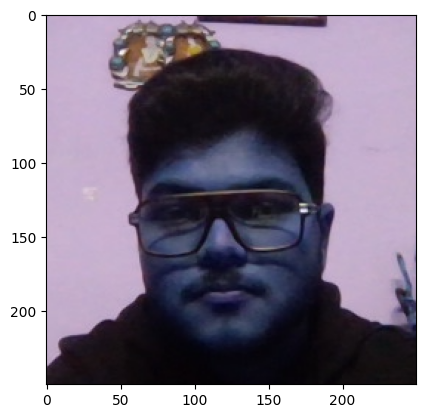

In [12]:
plt.imshow(frame)




In [13]:
#getting image directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'\\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\\*.jpg').take(3000)

In [14]:
dir_test = anchor.as_numpy_iterator()

In [15]:
print(dir_test.next())

b'data\\anchor\\fb832526-93ab-11ef-b011-e0c9e227498f.jpg'


In [16]:
#preprocessing- scale and resize
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [17]:
img = preprocess('data\\anchor\\96f30831-a894-11ef-b2db-3003c80f03d8.jpg')

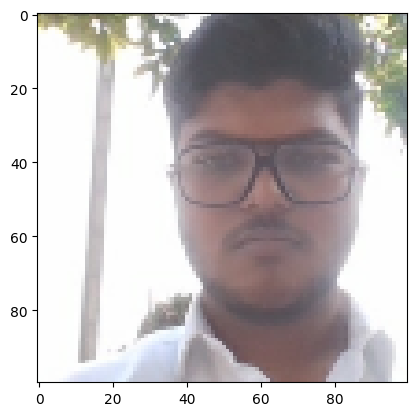

In [18]:
plt.imshow(img)

In [19]:
img.numpy().max() 

1.0

In [20]:
#Create Labelled Dataset
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [21]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [22]:
samples = data.as_numpy_iterator()
exampple = samples.next()
exampple

(b'data\\anchor\\e05712a1-a89b-11ef-9cfb-3003c80f03d8.jpg',
 b'data\\positive\\ed9e6198-a89f-11ef-81d4-3003c80f03d8.jpg',
 1.0)

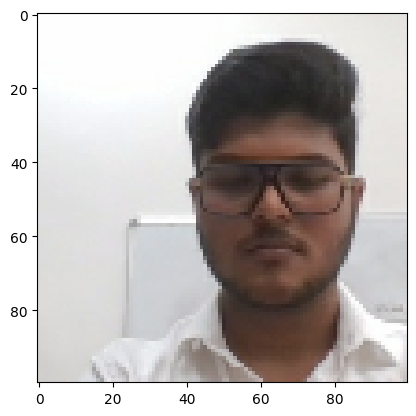

In [23]:
#Build Train and Test Partition

def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)
res = preprocess_twin(*exampple)
plt.imshow(res[0])

In [24]:
res[2]
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [25]:
#building embedding layer
inp = Input(shape=(100,100,3), name='input_image')

In [26]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [27]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [28]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [29]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [30]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [31]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')


In [32]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')


In [34]:
embedding = make_embedding()

In [35]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [37]:
l1 = L1Dist()

In [38]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img',shape=(100,100,3))

In [39]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [40]:
siamese_layer = L1Dist()

In [41]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

inp_embedding = Input(shape=(4096,))
val_embedding = Input(shape=(4096,))

# Define the Siamese layer's behavior
l1_dist = L1Dist()  # Assuming L1Dist is your custom distance layer
distance = l1_dist(inp_embedding, val_embedding)

# Create a model
siamese_layer = Model(inputs=[inp_embedding, val_embedding], outputs=distance)

# Test the model
result = siamese_layer([tf.random.normal((1, 4096)), tf.random.normal((1, 4096))])
print(result)



tf.Tensor([[0.90632397 0.7199067  2.4327617  ... 1.0368347  0.0346096  0.42423272]], shape=(1, 4096), dtype=float32)


In [42]:
classifier = Dense(1, activation='sigmoid')(distance)

In [43]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_23>

In [44]:
siamese_network = Model(inputs = [input_image, validation_image], outputs=classifier, name='Siamesenetwork')

In [45]:
siamese_network.summary()

Model: "Siamesenetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ input_layer[0][0… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [47]:
from tensorflow.keras import layers, models
import tensorflow as tf

def make_siamese_model(input_shape=(100, 100, 3)):
    # Define the base model (embedding model)
    input_image = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu')(input_image)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)

    embedding = models.Model(inputs=input_image, outputs=x, name="embedding")

    input_img = layers.Input(shape=input_shape)
    validation_img = layers.Input(shape=input_shape)

    encoded_input = embedding(input_img)
    encoded_validation = embedding(validation_img)

    # Lambda layer with output shape explicitly defined
    distance = layers.Lambda(
        lambda tensors: tf.abs(tensors[0] - tensors[1]),
        output_shape=(4096,)  # Explicitly define output shape
    )([encoded_input, encoded_validation])

    output = layers.Dense(1, activation='sigmoid')(distance)

    siamese_model = models.Model(inputs=[input_img, validation_img], outputs=output, name="siamese_network")

    return siamese_model

siamese_model = make_siamese_model()
siamese_model.summary()

Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 67,631,360 │ input_layer_3[0]… │
│ (Functional)        │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │      4,097 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,635,457 (258.01 MB)

 Trainable params: 67,635,457 (258.01 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [49]:
opt = tf.keras.optimizers.Adam(1e-4) 

In [50]:
#Establish Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

In [51]:
test_batch = train_data.as_numpy_iterator()

In [52]:
batch_1 = test_batch.next()

In [53]:
x= batch_1[:2]

In [54]:
y = batch_1[2]

In [55]:
y


array([0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
      dtype=float32)

In [56]:
np.array(x).shape

(2, 16, 100, 100, 3)

In [57]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        x = batch[:2]
        y=batch[2] #get label

        yhat = siamese_model(x, training=True)

        loss = binary_cross_loss(y, yhat) #loss calculated.
    print(loss)
    
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    return loss


In [58]:
def train(data, EPOCHS):
    #loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n EPOCH {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        
        if epoch % 10 == 0:
            #evaluate model on validation set3
            checkpoint.save(file_prefix = checkpoint_prefix)
        

In [59]:
EPOCHS = 15

In [60]:
train(train_data, EPOCHS)


 EPOCH 1/15
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)


C:\Users\akshi\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_34', 'keras_tensor_35']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 780ms/step

 EPOCH 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 733ms/step

 EPOCH 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 705ms/step

 EPOCH 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 726ms/step

 EPOCH 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 712ms/step

 EPOCH 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 761ms/step

 EPOCH 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 700ms/step

 EPOCH 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 686ms/step

 EPOCH 9/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 708ms/step

 EPOCH 10/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 741ms/step

 EPOCH 11/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 736ms/step

 EPOCH 12/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 698ms/step

 EPOCH 13/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 665ms/step

 EPOCH 14/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 656ms/step

 EPOCH 15/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 707ms/step


In [61]:
from tensorflow.keras.metrics import Precision, Recall

In [62]:
test_input , test_val, y_true = test_data.as_numpy_iterator().next()

In [63]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


array([[7.0038848e-03],
       [5.5026224e-08],
       [9.9987715e-01],
       [5.4170382e-03],
       [9.9999595e-01],
       [9.9063766e-01],
       [1.0380413e-09],
       [1.5003757e-04],
       [9.9999148e-01],
       [9.9976665e-01],
       [1.9958352e-06],
       [3.4082120e-06],
       [9.9999362e-01],
       [5.4761457e-01],
       [6.9618191e-12],
       [1.1238367e-12]], dtype=float32)

In [64]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0]

In [65]:
y_true

array([0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
      dtype=float32)

In [66]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

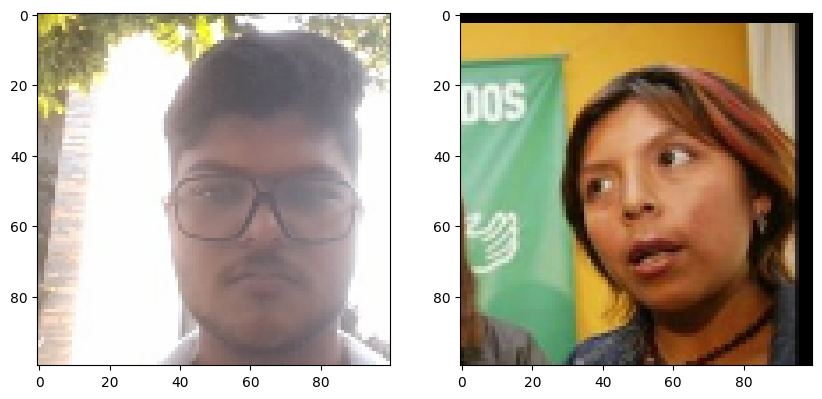

In [67]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()

In [68]:
siamese_model.save('siamesemodel.h5')

In [69]:
model = tf.keras.models.load_model(
    'siamesemodel.h5',
    custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy}
)


In [70]:
model.summary()

Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 67,631,360 │ input_layer_3[0]… │
│ (Functional)        │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │      4,097 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,635,457 (258.01 MB)

 Trainable params: 67,635,457 (258.01 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
os.listdir(os.path.join('application_data', 'verification_images'))

['03c73a9d-93ac-11ef-a173-e0c9e227498f.jpg',
 '04f671e4-a88f-11ef-af20-3003c80f03d8.jpg',
 '053ddc47-a88f-11ef-82b0-3003c80f03d8.jpg',
 '05617d57-a88f-11ef-bd85-3003c80f03d8.jpg',
 '05a1d49e-a88f-11ef-861e-3003c80f03d8.jpg',
 '05be483e-a88f-11ef-9c5c-3003c80f03d8.jpg',
 '1dcca700-a89d-11ef-99fb-3003c80f03d8.jpg',
 '1df76dfb-a89d-11ef-ba56-3003c80f03d8.jpg',
 '1e1b154e-a89d-11ef-9363-3003c80f03d8.jpg',
 '23d00ddd-a89d-11ef-8179-3003c80f03d8.jpg',
 '25d17f51-a89d-11ef-b38d-3003c80f03d8.jpg',
 '4727ed9d-a6ef-11ef-9926-d3db5806e81d.jpg',
 '474bb3aa-a6ef-11ef-a803-d3db5806e81d.jpg',
 '47687280-a6ef-11ef-bc07-d3db5806e81d.jpg',
 '479a553f-a6ef-11ef-8488-d3db5806e81d.jpg',
 '47b6d404-a6ef-11ef-9361-d3db5806e81d.jpg',
 '978b0cb5-a894-11ef-8a61-3003c80f03d8.jpg',
 '9809ceba-a894-11ef-9ada-3003c80f03d8.jpg',
 '98498372-a894-11ef-8bec-3003c80f03d8.jpg',
 'a7917b43-a890-11ef-831b-3003c80f03d8.jpg',
 'a7ee1607-a890-11ef-9fab-3003c80f03d8.jpg',
 'ab21dda1-9123-11ef-a3d2-e0c9e227498f.jpg',
 'ba579b88

In [72]:
os.path.join('application_data', 'input_images', 'input_image.jpg')  #by hitting v

'application_data\\input_images\\input_image.jpg'

In [73]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)


application_data\verification_images\03c73a9d-93ac-11ef-a173-e0c9e227498f.jpg
application_data\verification_images\04f671e4-a88f-11ef-af20-3003c80f03d8.jpg
application_data\verification_images\053ddc47-a88f-11ef-82b0-3003c80f03d8.jpg
application_data\verification_images\05617d57-a88f-11ef-bd85-3003c80f03d8.jpg
application_data\verification_images\05a1d49e-a88f-11ef-861e-3003c80f03d8.jpg
application_data\verification_images\05be483e-a88f-11ef-9c5c-3003c80f03d8.jpg
application_data\verification_images\1dcca700-a89d-11ef-99fb-3003c80f03d8.jpg
application_data\verification_images\1df76dfb-a89d-11ef-ba56-3003c80f03d8.jpg
application_data\verification_images\1e1b154e-a89d-11ef-9363-3003c80f03d8.jpg
application_data\verification_images\23d00ddd-a89d-11ef-8179-3003c80f03d8.jpg
application_data\verification_images\25d17f51-a89d-11ef-b38d-3003c80f03d8.jpg
application_data\verification_images\4727ed9d-a6ef-11ef-9926-d3db5806e81d.jpg
application_data\verification_images\474bb3aa-a6ef-11ef-a803-d3d

In [74]:
def verify(frame, model, detection_threshold, verification_threshold):
    
    result = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', 'verification_images.jpg'))

        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results , verified


In [75]:
# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     ret, frame = cap.read()
#     frame = frame[120:120+250,200:200+250, :]

#     cv2.imshow('Verification', frame)

#     if cv2.waitKey(10) &0xFF == ord('v'):
#         cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
#         results, verified = verify(model, 0.9, 0.7,0.5)
#         print(verified)
    
#     if cv2.waitKey(10) & 0xFF == ord('q'):
#         break

# # cap.release()
# cv2.destroyAllWindows()

In [76]:

import os
import cv2
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Ensure necessary folders exist
os.makedirs(os.path.join('application_data', 'input_image'), exist_ok=True)
os.makedirs(os.path.join('application_data', 'verification_images'), exist_ok=True)

def preprocess(file_path):
    """Preprocess image (resize, normalize)."""
    img = cv2.imread(file_path)
    if img is None:
        raise ValueError(f"Failed to read image: {file_path}")
    img = cv2.resize(img, (100, 100))  # Resize to a fixed size
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = img.astype(np.float32) / 255.0  # Normalize to [0, 1] and ensure float32
    return img

class SimpleImageComparer:
    def compare(self, image1, image2):
        """Compare two images and return a similarity score."""
        # Ensure images are in grayscale
        gray1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
        gray2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
        
        # Compute the Mean Squared Error between the two images
        mse = np.mean((gray1 - gray2) ** 2)
        
        # Convert MSE to a similarity score (higher means more similar)
        similarity = 1 / (1 + mse)
        
        return similarity

def verify(comparer, verification_threshold):
    """Compare input image with verification images."""
    input_image_path = os.path.join('application_data', 'input_image', 'input_image.jpg')
    verification_folder = os.path.join('application_data', 'verification_images')
    
    # Check if the input image exists
    if not os.path.exists(input_image_path):
        print(f"Error: Input image '{input_image_path}' not found.")
        return False
    
    # Check if the verification folder exists
    if not os.path.exists(verification_folder):
        print(f"Error: Folder '{verification_folder}' does not exist.")
        return False

    # Preprocess input image
    input_image = preprocess(input_image_path)
    
    for image_name in os.listdir(verification_folder):
        verification_image_path = os.path.join(verification_folder, image_name)
        
        # Preprocess verification image
        verification_image = preprocess(verification_image_path)
        
        # Compare images
        similarity = comparer.compare(input_image, verification_image)
        # print(f"Similarity with {image_name}: {similarity:.2f}")  # Debugging
        
        # Check against threshold
        if similarity > verification_threshold:
            return True  # Images are considered the same
    
    return False  # No match found

# Capture the input image (for testing purposes)
cap = cv2.VideoCapture(0)
comparer = SimpleImageComparer()

while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        frame = frame[120:120+250, 200:200+250, :]  # Crop area to capture
        
        cv2.imshow('Verification', frame)
        
        # Verification trigger
        if cv2.waitKey(10) & 0xFF == ord('v'):
            # Ensure folder exists and save image
            os.makedirs(os.path.join('application_data', 'input_image'), exist_ok=True)
            cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
            print("Input image saved.")
            
            # Run verification with a higher threshold (e.g., 0.95)
            threshold = 0.95  # Set a higher threshold for stricter verification
            try:
                verified = verify(comparer, verification_threshold=threshold)
                print(f"Verification Result: {'Images Matched' if verified else 'Images doesnot Matched'}")
            except Exception as e:
                print(f"An error occurred during verification: {str(e)}")
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
             
            break
            
cap.release()
cv2.destroyAllWindows()

Input image saved.
Verification Result: Images doesnot Matched
Input image saved.
Verification Result: Images doesnot Matched
Input image saved.
Verification Result: Images doesnot Matched


In [77]:
import cv2
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()